In [1]:
### Import the packages

In [34]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline
import random
import math

import check_test
from plot_utils import plot_values

In [35]:
# Create the environment for CliffWalkingEnv
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [36]:
# Checking the Action space(a for all Action(A) )
#checking all the states (s for all S)
print('There are {} type of action'.format(env.action_space))
print('Tere are {} states in the Environment'.format(env.observation_space))

There are Discrete(4) type of action
Tere are Discrete(48) states in the Environment


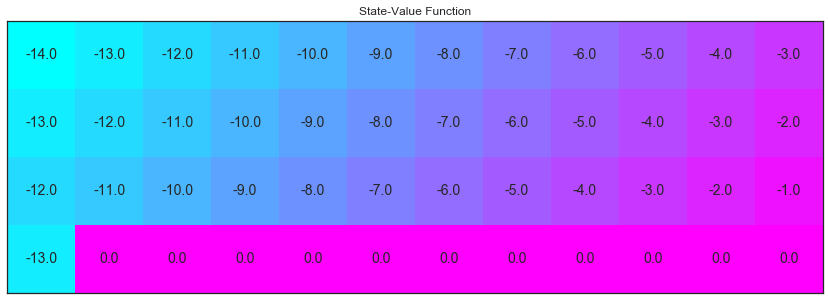

In [37]:
# WE GOT THE OPTIMAL STATE-VALUE FUNCTION BELOW. 
'''Think about it by visualizing the below code about why this is
Optimal State-Value function Happy Learning :)'''

#Intial values of all the states is Zero.
V_opt = np.zeros((4,12))

#Initializing  the first row for the state-value function with the discounted return of each column
V_opt[0:13][0] = -np.arange(3,15)[::-1]

# Initializing the second row with the discounted return
V_opt[0:13][1] = -np.arange(3,15)[::-1] + 1

# Initialzing the Third row with the discounted return
V_opt[0:13][2] = -np.arange(3,15)[::-1] + 2

'''Remember final row is the cliff. So, Except Row[3] column[0] 
with the discounted return of -13. All will give return of Zero'''
V_opt[3][0] = -13


# Visualize it and observe it :)
plot_values(V_opt)

### Let's implement all the Temporal-Difference Learning techniques one by one

### Part 1: TD Control: Sarsa or (Sarsa(0))

In this section, we  will write implementation for the Sarsa control algorithm.

Algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.


In [42]:
# Let's Define our Helper Function 
def update_Q_sarsa(alpha, gamma, Q, state, action, reward,
                   next_state = None, next_action = None):
    
    #Estimating the Q-table for current state
    current = Q[state][action]
    
    #get the value of stat, action pair at next time step
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0
    
    #Construct TD target
    target = reward + (gamma*Qsa_next)
    
    #get the updated value
    new_value = current + (alpha * (target-current)) #Alernative estimate as per book
    
    return new_value


def epsilon_greedy(Q, state, nA, eps):
    '''
    Select the epsilon-greedy action for supplied state.
    
    Parameters:-
    Q(dictionary): action-value function
    state (int) : current state
    nA : number of actions in the environment
    eps(float) : epsilon
    '''
    
    #select greedy action with probability epsilon
    if random.random() > eps:
        return np.argmax(Q[state])
    else:
        return random.choice(np.arange(env.action_space.n))
        


In [43]:
def sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        score = 0                                             # initialize score
        state = env.reset()                                   # start episode
        
        eps = 1.0 / i_episode                                 # set value of epsilon
        action = epsilon_greedy(Q, state, nA, eps)            # epsilon-greedy action selection
        
        while True:
            next_state, reward, done, info = env.step(action) # take action A, observe R, S'
            score += reward                                   # add reward to agent's score
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps) # epsilon-greedy action
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                
                state = next_state     # S <- S'
                action = next_action   # A <- A'
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                tmp_scores.append(score)    # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    
   
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [44]:
# All the best :^)

Episode 500000/500000

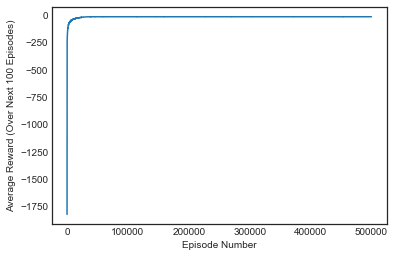

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  0  1  1  0  1  1  3  1  3  1  2]
 [ 0  1  1  0  1  1  2  1  1  3  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


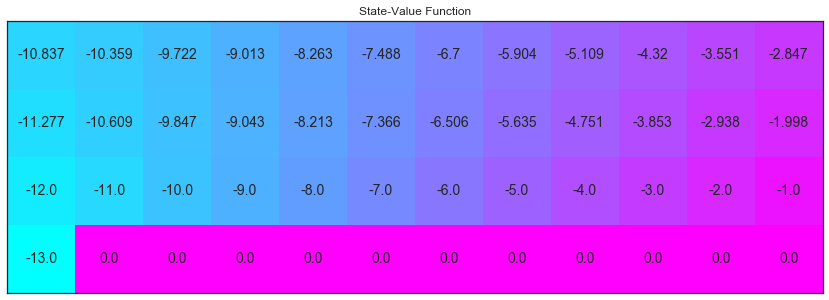

In [45]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 500000, .001)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)